# pytorch encoder decoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
basemodel_name = 'tf_efficientnet_b5_ap'


In [3]:
print('Loading base model ()...'.format(basemodel_name), end='')
basemodel = torch.hub.load('rwightman/gen-efficientnet-pytorch', basemodel_name, pretrained=True)
print('Done.')

# Remove last layer
print('Removing last two layers (global_pool & classifier).')
basemodel.global_pool = nn.Identity()
basemodel.classifier = nn.Identity()

Loading base model ()...

Using cache found in /Users/vivek/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).


In [19]:
type(basemodel)

geffnet.gen_efficientnet.GenEfficientNet

In [4]:
x = torch.rand(2, 3, 480, 640)
features = [x]

In [ ]:
for k, v in basemodel._modules.items():
    if (k == 'blocks'):
        for ki, vi in v._modules.items():
            features.append(vi(features[-1]))
    else:
        features.append(v(features[-1]))
        

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    def __init__(self, backend):
        super(Encoder, self).__init__()
        self.original_model = backend

    def forward(self, x):
        features = [x]
        for k, v in self.original_model._modules.items():
            if k == 'blocks':
                for ki, vi in v._modules.items():
                    features.append(vi(features[-1]))
            else:
                features.append(v(features[-1]))
        return features


def visualize_feature_maps(features, max_channels=8, figsize=(16, 4)):
    """
    Visualizes the first few channels of each feature map in a row.
    
    Args:
        features (list of Tensors): Feature maps from the encoder.
        max_channels (int): Maximum number of channels to visualize per feature map.
        figsize (tuple): Size of each subplot row.
    """
    for i, feature in enumerate(features):
        # Only visualize 4D feature maps (batch, channels, height, width)
        if len(feature.shape) != 4:
            continue
        b, c, h, w = feature.shape
        feature = feature[0]  # Visualize first sample in batch
        
        # Pick up to max_channels to display
        n_channels = min(c, max_channels)
        fig, axes = plt.subplots(1, n_channels, figsize=figsize)
        fig.suptitle(f"Layer {i} - Shape: {feature.shape}")
        
        for j in range(n_channels):
            ax = axes[j]
            fmap = feature[j].detach().cpu().numpy()
            ax.imshow(fmap, cmap='viridis')
            ax.axis('off')
            ax.set_title(f"Channel {j}")
        
        plt.tight_layout()
        plt.show()

In [7]:
encoder = Encoder(basemodel)

In [8]:
dummy_input = torch.randn(1, 3, 456, 456) 
l = encoder.forward(dummy_input)

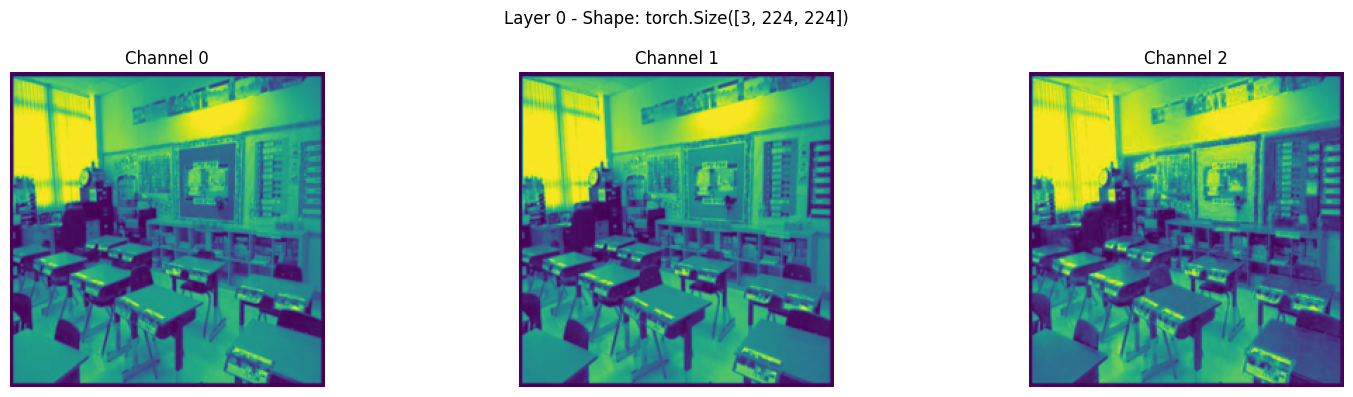

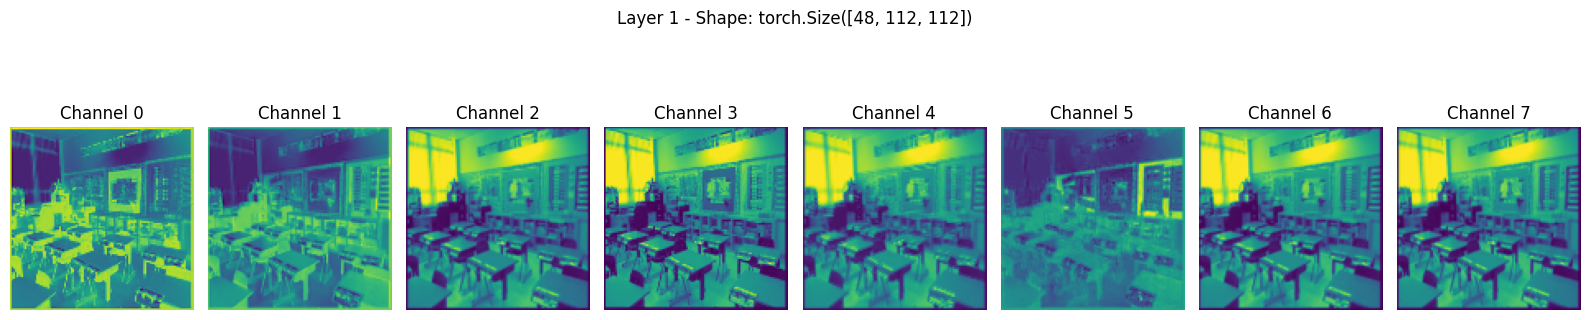

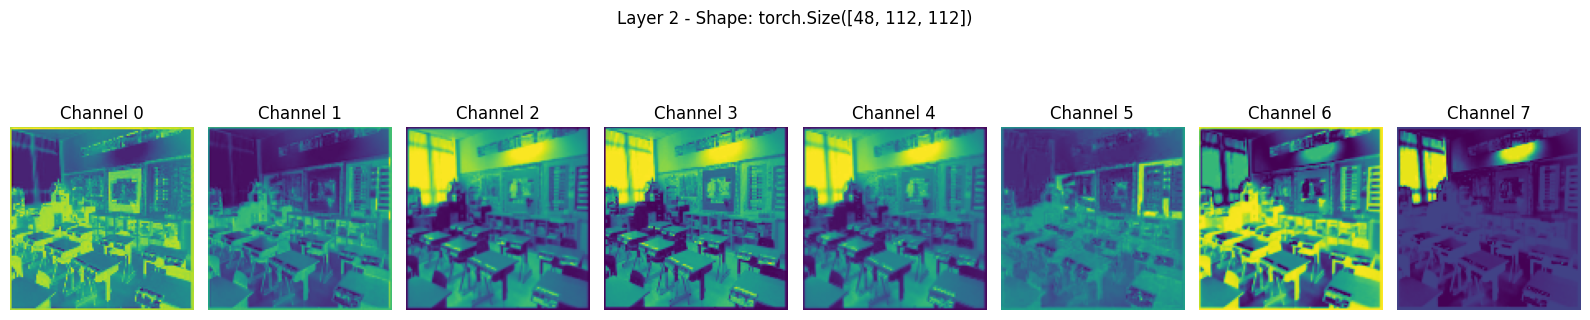

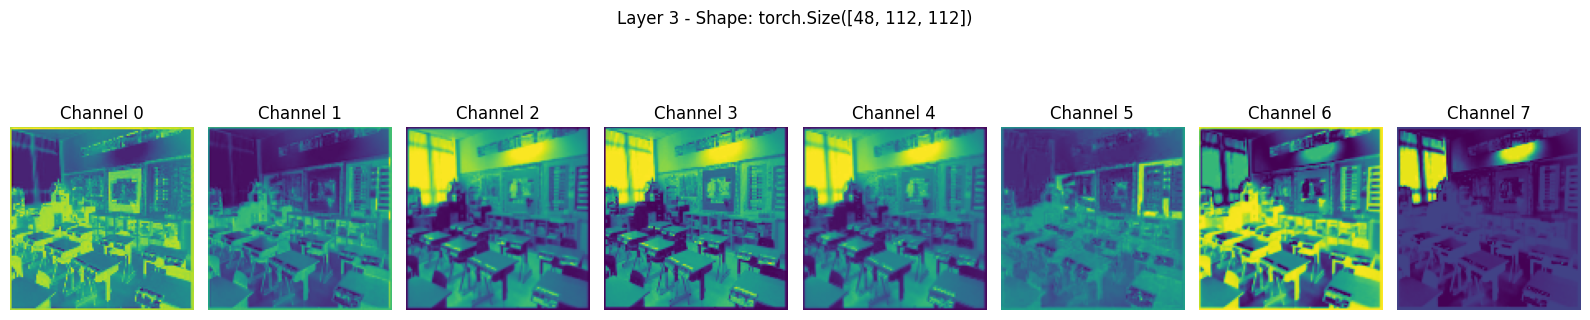

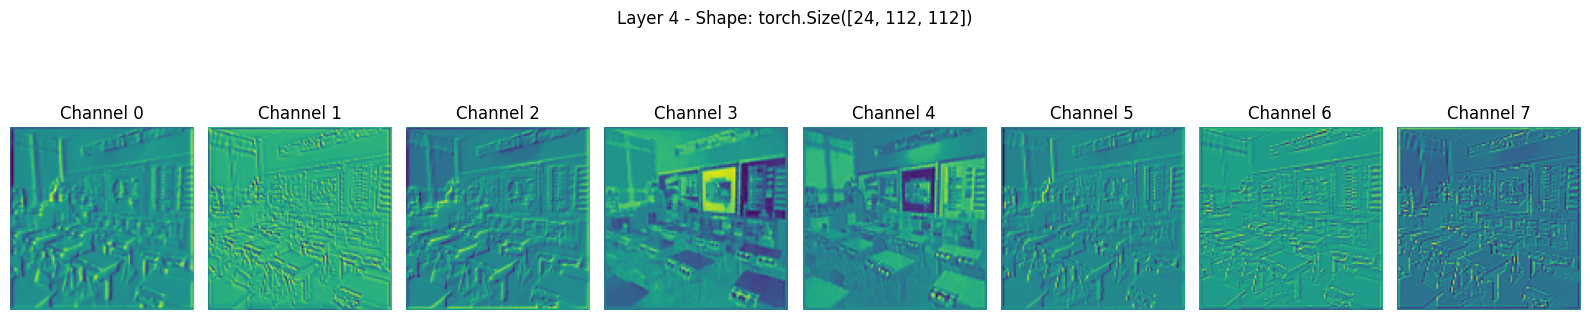

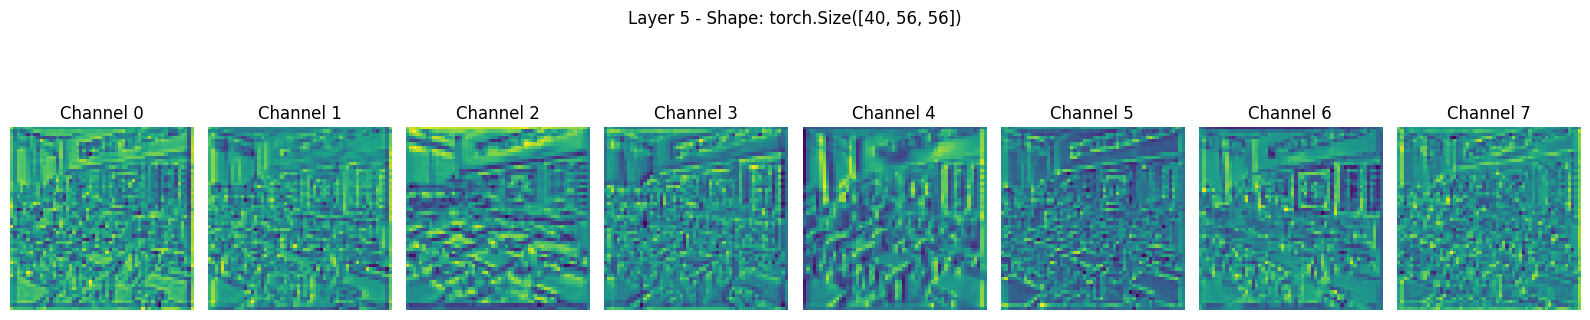

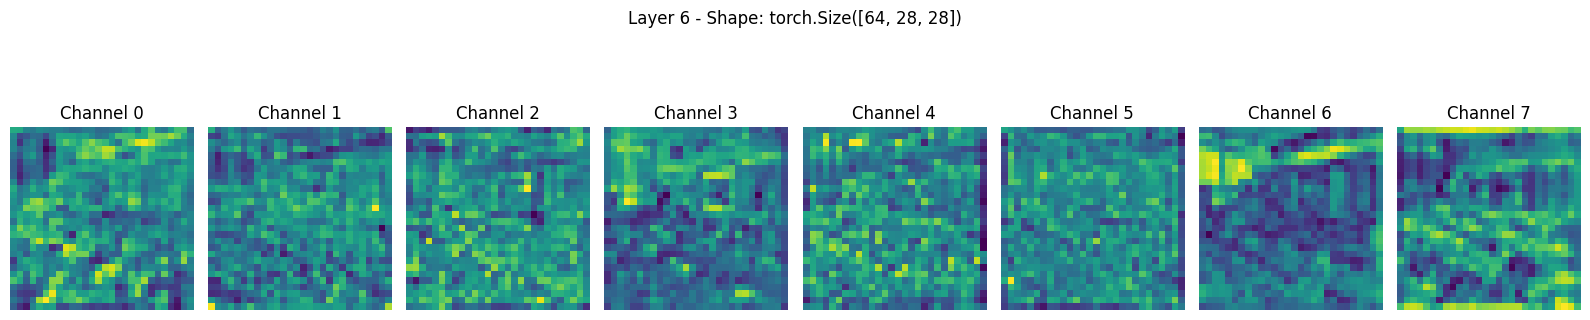

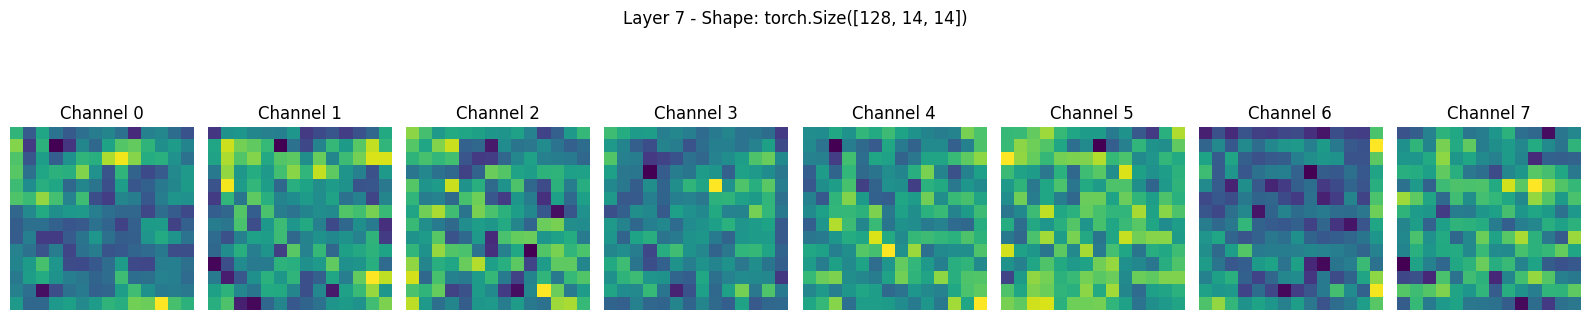

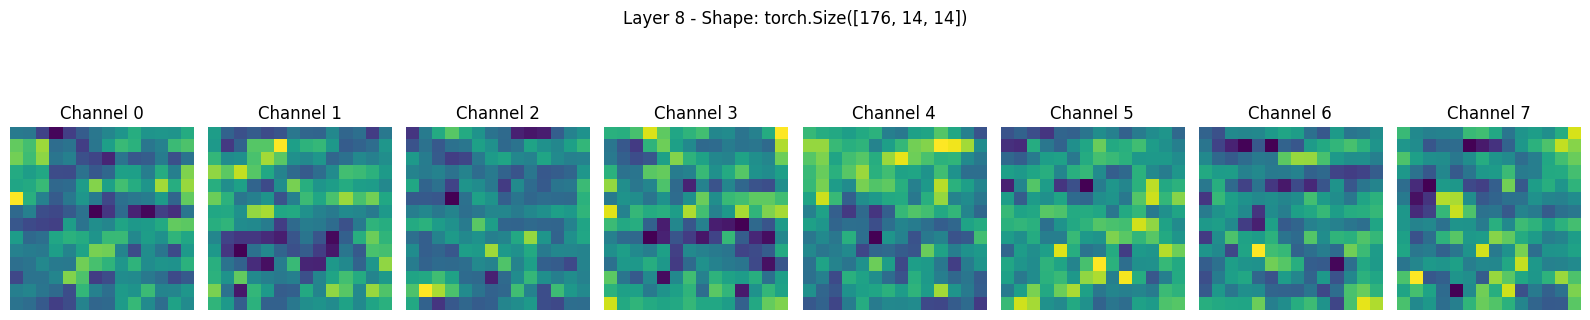

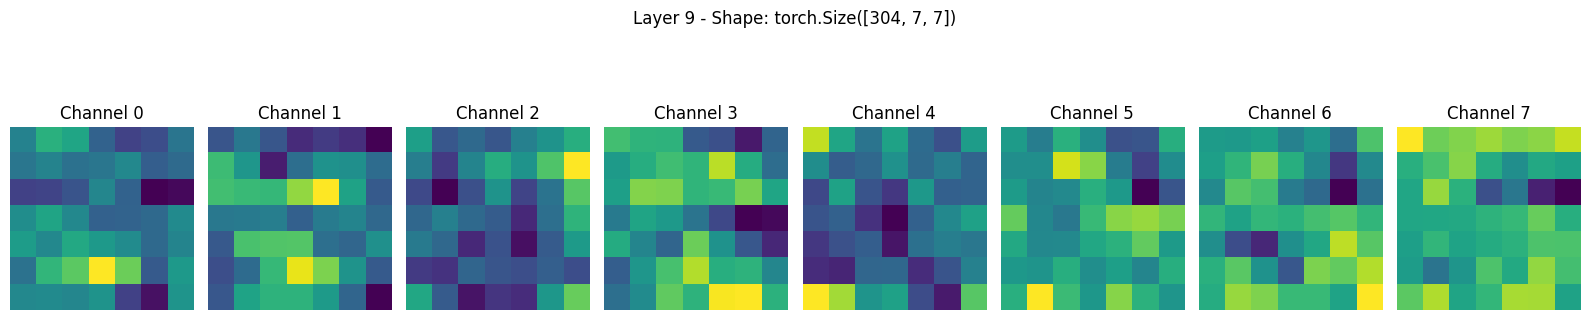

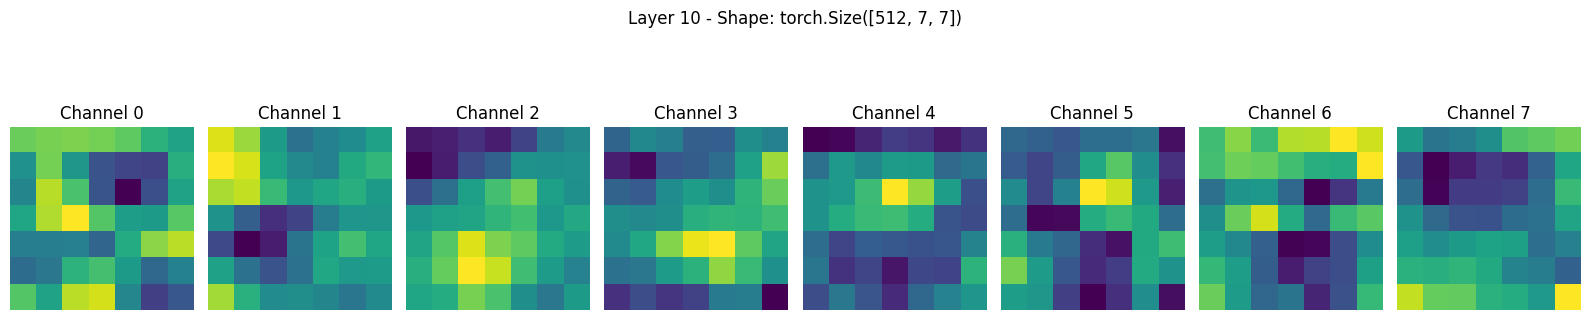

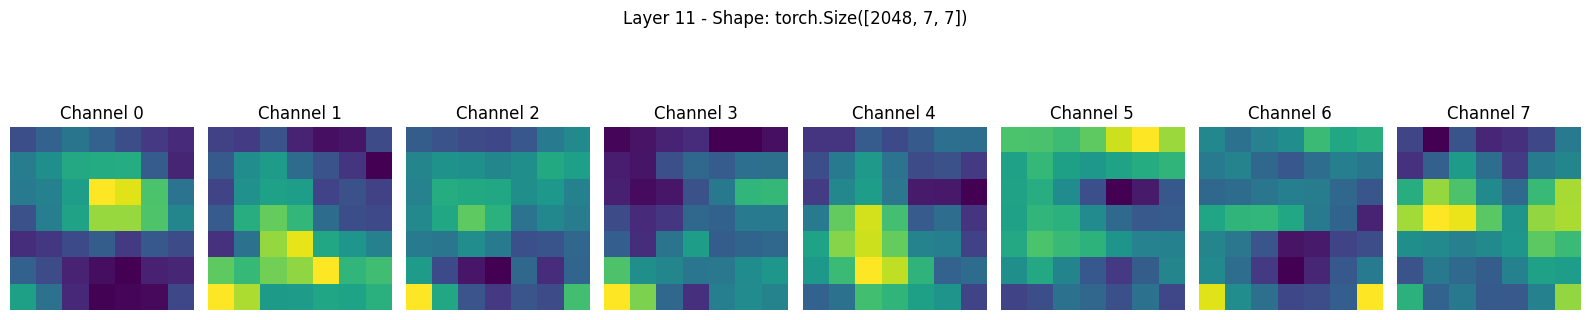

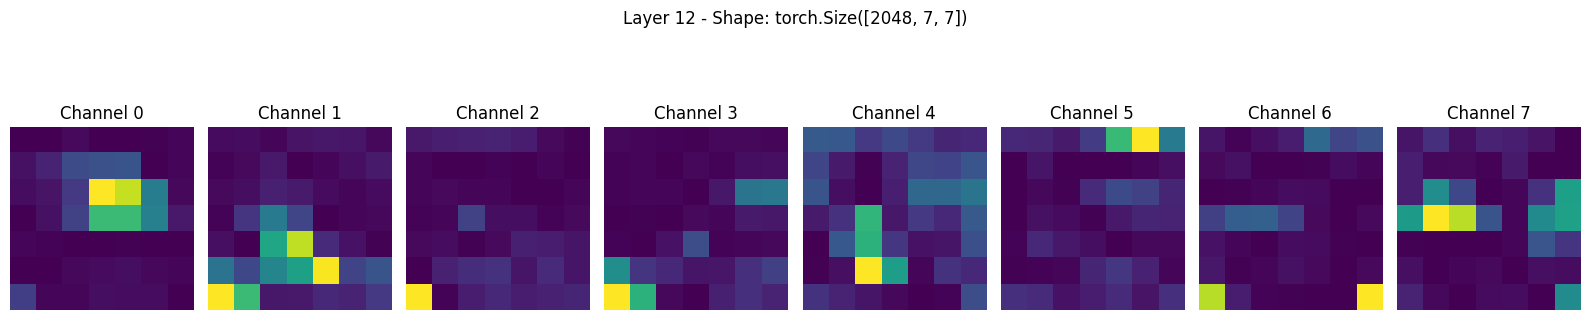

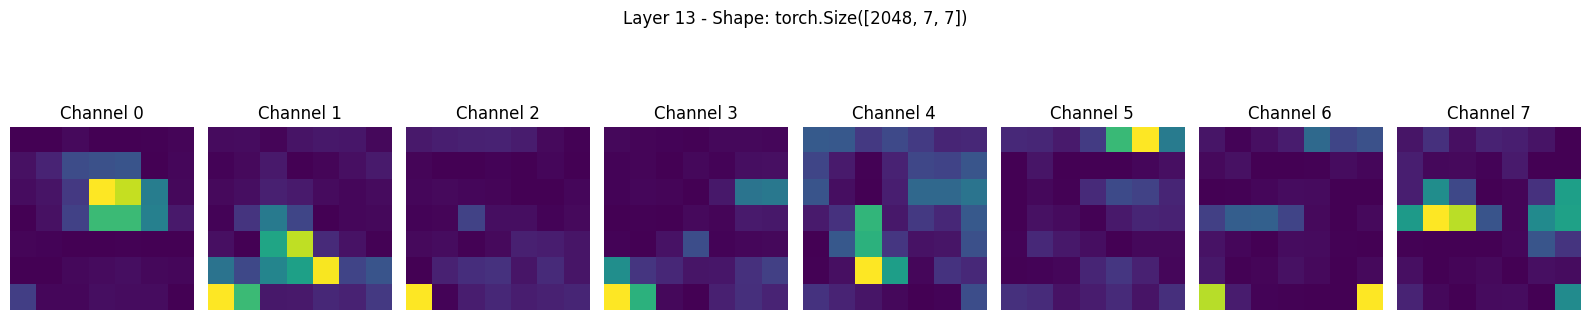

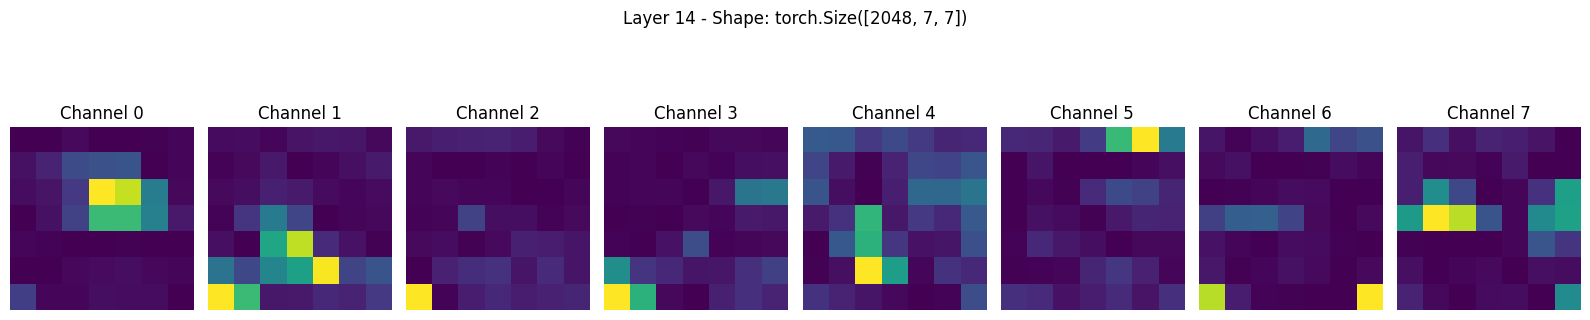

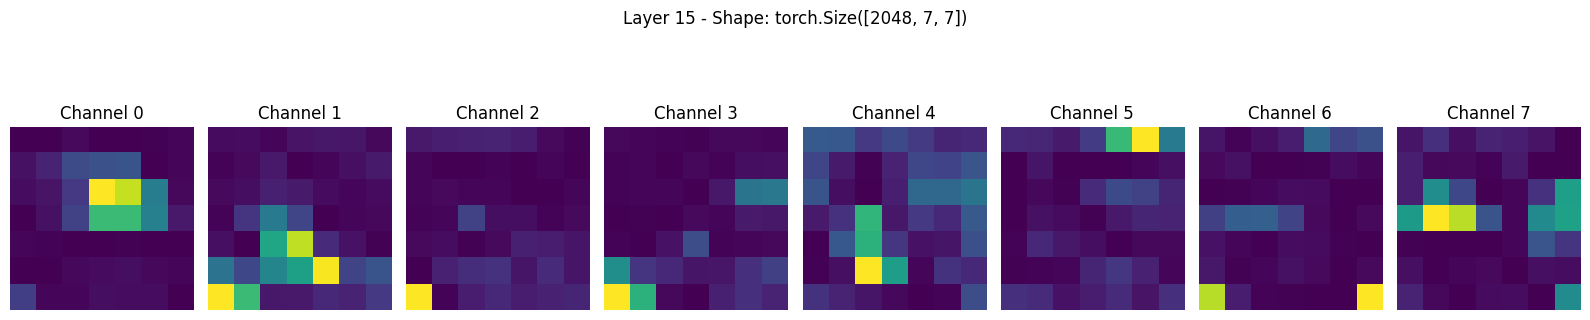

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ---------- Step 1: Encoder Definition ----------
class Encoder(nn.Module):
    def __init__(self, backend):
        super(Encoder, self).__init__()
        self.original_model = backend

    def forward(self, x):
        features = [x]
        for k, v in self.original_model._modules.items():
            if k == 'blocks':
                for ki, vi in v._modules.items():
                    features.append(vi(features[-1]))
            else:
                features.append(v(features[-1]))
        return features

# ---------- Step 2: Feature Map Visualization ----------
def visualize_feature_maps(features, max_channels=8, figsize=(16, 4)):
    for i, feature in enumerate(features):
        if len(feature.shape) != 4:
            continue
        b, c, h, w = feature.shape
        feature = feature[0]  # First sample in batch

        n_channels = min(c, max_channels)
        fig, axes = plt.subplots(1, n_channels, figsize=figsize)
        fig.suptitle(f"Layer {i} - Shape: {feature.shape}")

        for j in range(n_channels):
            ax = axes[j]
            fmap = feature[j].detach().cpu().numpy()
            ax.imshow(fmap, cmap='viridis')
            ax.axis('off')
            ax.set_title(f"Channel {j}")
        
        plt.tight_layout()
        plt.show()

# ---------- Step 3: Load and Preprocess Image ----------
def load_image(image_path, size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),  # Converts HWC [0,255] → CHW [0.0,1.0]
    ])
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0)  # Add batch dimension: [1, 3, H, W]
    return tensor

# ---------- Step 4: Run Everything ----------
if __name__ == '__main__':
    # Example usage
    image_path = 'classroom__rgb_00283.jpg'  # Replace with your actual image path
    input_tensor = load_image(image_path)  # Shape: [1, 3, 224, 224]

    # Replace this with your actual model
    backend_model = basemodel  # Ensure this has .conv_stem, .blocks etc.
    backend_model.eval()

    encoder = Encoder(backend_model)
    with torch.no_grad():
        features = encoder(input_tensor)

    visualize_feature_maps(features)

# tensorflow

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [13]:
input_shape=(480, 640, 3)
base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_shape=input_shape)

2025-05-21 12:44:03.156137: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-21 12:44:03.156167: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-21 12:44:03.156174: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-21 12:44:03.156190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 12:44:03.156203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
x = tf.random.normal([2, 480, 640, 3])  # batch of 2 RGB images, height=480, width=640
features = [x]
for layer in base_model.layers:
    x = layer(x)
    features.append(x)

TypeError: too many positional arguments

In [20]:
type(base_model)

keras.src.models.functional.Functional

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras import layers


# ----------------------
# Encoder using EfficientNetB5
# ----------------------
class Encoder(tf.keras.Model):
    def __init__(self, input_shape=(480, 640, 3)):
        super(Encoder, self).__init__()

        # Load pretrained EfficientNetB5 without classifier (top)
        base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=input_shape)

        # Specify skip connection layers
        skip_layer_names = [
            'block2a_activation',  # x_block0
            'block3a_activation',  # x_block1
            'block4a_activation',  # x_block2
            'block6a_activation',  # x_block3
            'top_activation'       # x_block4 (bottleneck input)
        ]

        # Extract outputs from these layers
        skip_outputs = [base_model.get_layer(name).output for name in skip_layer_names]

        # Create the intermediate feature model
        self.feature_extractor = Model(inputs=base_model.input, outputs=skip_outputs)

    def call(self, x):
        return self.feature_extractor(x)  # returns [x_block0, x_block1, x_block2, x_block3, x_block4]


# ----------------------
# Testing the Encoder
# ----------------------
if __name__ == '__main__':
    # Create encoder
    encoder = Encoder(input_shape=(480, 640, 3))

    # Example input (batch of 2 images)
    x = tf.random.normal([2, 480, 640, 3])

    # Get intermediate features for skip connections
    features = encoder(x)

    for i, f in enumerate(features):
        print(f"x_block{i} shape:", f.shape)

x_block0 shape: (2, 120, 160, 144)
x_block1 shape: (2, 60, 80, 240)
x_block2 shape: (2, 30, 40, 384)
x_block3 shape: (2, 15, 20, 1056)
x_block4 shape: (2, 15, 20, 2048)


In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB5, efficientnet
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
import cv2


class Encoder(tf.keras.Model):
    def __init__(self, input_shape=(480, 640, 3)):
        super(Encoder, self).__init__()

        # Load pretrained EfficientNetB5 (no top classification layer)
        base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=input_shape)

        # Layer names to tap for skip connections
        self.skip_layer_names = [
            'block2a_activation',  # x_block0
            'block3a_activation',  # x_block1
            'block4a_activation',  # x_block2
            'block6a_activation',  # x_block3
            'top_activation'       # x_block4 (deepest)
        ]

        # Extract those outputs
        skip_outputs = [base_model.get_layer(name).output for name in self.skip_layer_names]

        # Wrap into a model
        self.feature_extractor = Model(inputs=base_model.input, outputs=skip_outputs)

    def call(self, x):
        return self.feature_extractor(x)

    def extract_features_from_image(self, img, resize_shape=(480, 640)):
        """
        img: input image as numpy array [H, W, C] in RGB format
        resize_shape: target size (H, W)
        """
        # Resize image
        img_resized = cv2.resize(img, resize_shape[::-1])  # cv2 uses (W, H)

        # Convert to float32 & preprocess
        img_preprocessed = efficientnet.preprocess_input(img_resized.astype(np.float32))

        # Add batch dimension
        img_tensor = tf.expand_dims(img_preprocessed, axis=0)

        # Extract features
        features = self(img_tensor)
        return features


# ----------------------
# Test the Encoder with an image
# ----------------------
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # Load an image (you can replace this with any RGB image path)
    img = cv2.imrea
    img = keras_image.img_to_array(img)

    # Create encoder
    encoder = Encoder()

    # Extract intermediate features
    features = encoder.extract_features_from_image(img)

    # Print and visualize shapes
    for i, f in enumerate(features):
        print(f"x_block{i} shape: {f.shape}")

        # Optional: visualize the first channel
        fmap = f[0, :, :, 0].numpy()
        plt.figure()
        plt.imshow(fmap, cmap='viridis')
        plt.title(f"Feature Map x_block{i} (channel 0)")
        plt.axis('off')

    plt.show()

Exception: URL fetch failure on https://i.imgur.com/Bvro0YD.png: 429 -- Unknown Error

# TransformerEncoderLayer - 1


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class TransformerEncoderLayer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, ff_dim=1024, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        # Feedforward network (FFN)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),  # Hidden layer
            layers.Dense(embedding_dim)  # Output layer (same dimension as input)
        ])
        
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
            # Self-Attention Layer
            attn_output = self.attn(inputs, inputs)
            # Residual Connection + Layer Normalization
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1(inputs + attn_output)
            
            # Feedforward Network
            ffn_output = self.ffn(out1)
            # Residual Connection + Layer Normalization
            ffn_output = self.dropout2(ffn_output, training=training)
            out2 = self.layernorm2(out1 + ffn_output)
            
            return out2
    

In [35]:

# Example Usage
embedding_dim = 128
num_heads = 4
dim_feedforward = 1024
num_layers = 6  # Number of Encoder Layers

# Create a transformer encoder layer
encoder_layer = TransformerEncoderLayer(embedding_dim, num_heads, ff_dim=dim_feedforward)

# Example input (batch_size, sequence_length, embedding_dim)
x = tf.random.uniform((16, 132, embedding_dim))  # (Batch size, Sequence length, Embedding dimension)

# Pass input through the Transformer Encoder Layer
output = encoder_layer(x)

print(output.shape)  # Output shape should be (batch_size, seq_len, embedding_dim)

(16, 132, 128)


# transformerEncoderLayer


In [38]:

#creating the transformerEncoder from TransformerEncoderBlock
transformer_layers = [
            TransformerEncoderLayer(embedding_dim=embedding_dim, num_heads=num_heads, ff_dim=1024)
            for _ in range(num_layers)
]

# patch generation

In [40]:
patch_size = 16
embedding_dim = 512


embedding_convPxP = layers.Conv2D(
            filters=embedding_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='valid',
            use_bias=False
        )

In [44]:
input_image = tf.keras.Input(shape=(64, 64, 3))  # (H, W, C)

In [45]:
output = embedding_convPxP(input_image)

In [50]:
output.shape

(None, 4, 4, 512)

In [51]:
class PatchTransformerEncoder(tf.keras.Model):
    def __init__(self, in_channels, patch_size=10, embedding_dim=128, num_heads=4, num_layers=4):
        super(PatchTransformerEncoder, self).__init__()

        #generating the traininable positional encodings
        self.positional_encodings = self.add_weight(
            shape=(16, embedding_dim),
            initializer='random_normal',
            trainable=True
        )
    

In [52]:
pt = PatchTransformerEncoder(in_channels=3)

In [53]:
pt.positional_encodings

<KerasVariable shape=(16, 128), dtype=float32, path=patch_transformer_encoder/variable>

# implenmenting the pathtransformerEncoder class